## Simple qubit rotation with Pennylane and TFQ

In this jupyter file we define a variational quantum circuit $V(\theta)$ that rotates an initial state $|0000\rangle$ into a target state with equal superposition $\sum_{\sigma_i} | \sigma_i \rangle$. The aim is that  $\langle 1111 | V(\theta) | 0000\rangle = 1$.

In [32]:
import pennylane as qml
from pennylane import numpy as np
from tqdm import tqdm_notebook as tqdm

## Pennylane version

Define the device `default.qubit` and a circuit where one layer contains a general rotation $R(\phi, \theta, \omega) = R_z(\omega)R_z(\theta)R_z(\phi)$ on each qubit, followed by entangling gates. We apply 2 layers. The $R(\phi, \theta, \omega)$ gate is a native in pennylane `qml.Rot()`. We use 4 qubits.

In [2]:
dev1 = qml.device("default.qubit", wires=4)

In [26]:
target_state = np.ones(2**4)/np.sqrt(2**4)
density = np.outer(target_state, target_state)

@qml.qnode(dev1)
def circuit(params):
    for j in range(2): # 2 layers
        for i in range(4): # 4 qubits
            qml.Rot(*params[j][i], wires=i)
        qml.CNOT(wires=[0,1])
        qml.CNOT(wires=[2,3])
        qml.CNOT(wires=[1,2])
    return qml.expval(qml.Hermitian(density, wires=[0,1,2,3]))

Define a cost function. In our case we want the overlap of the circuit output to be maximal with the targe_state. Therefore we minimize $1-\langle 1111 | V(\theta) | 0000\rangle$

In [27]:
def cost(var):
    return 1-circuit(var)

Initialize the parameters randomly. The shape of the parametrs is $(layers, number of qubits, 3)$ because for each layer and qubit we have 3 paramters.

In [31]:
init_params = np.random.rand(2, 4, 3) # 2 layers, 4 qubits, 3 parameters per rotation
print(cost(init_params))

0.8903620617110245


### Training

For the training we define a gradient descent optimizer and continuously update the parameters 

In [34]:
# initialise the optimizer
opt = qml.GradientDescentOptimizer(stepsize=0.4) # stepsize is the learning rate

# set the number of steps
steps = 100
# set the initial parameter values
params = init_params

for i in tqdm(range(steps)):
    # update the circuit parameters
    params = opt.step(cost, params)

    if (i + 1) % 10 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i + 1, cost(params)))

print("Optimized rotation angles: {}".format(params))

/Users/patrickhuembeli/anaconda3/envs/QC/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


IndexError: index 24 is out of bounds for axis 0 with size 24

If we check the final state we see that appart from a global pahse we find the target state.

In [30]:
circuit(params)
dev1.state

array([0.12707391-0.21695261j, 0.12705885-0.21694297j,
       0.12655056-0.21482595j, 0.12651544-0.21478174j,
       0.12674142-0.21634656j, 0.12670667-0.21630278j,
       0.126182  -0.2141564j , 0.12616779-0.21414746j,
       0.126182  -0.21415639j, 0.12616779-0.21414746j,
       0.12674142-0.21634656j, 0.12670667-0.21630279j,
       0.12655056-0.21482595j, 0.12651543-0.21478173j,
       0.12707391-0.21695261j, 0.12705885-0.21694297j])

## TFQ version

In [1]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

### Generate symbols

I did not figure out, how I can do the gradients in TFQ without using symbols, this seems to be mandatory for tfq. I don't reallay see the advantage so far. Especially the evaluation with the resolver function seems a bit odd and unnecessary.

The definition of the circuit is almost the same as in Pennylane.

There is no option to define a projections operator to calculate the overlap with a target state because they are not unitary. This gives a bit less room to play with TFQ. I assume the idea was, that these gates are not really feasible on a real quantum device.

% Instaed of defining a hermitian matrix that gives the overlap with the target state, we can simply measure the operator $M = 1/4*(X_1 + X_2 + X_3 + X_4)$ and minimize the loss $1-\langle M \rangle$.

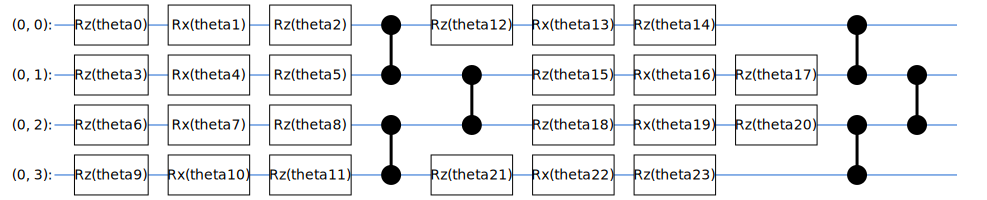

In [3]:
def generate_circuit(nr_of_qubits, layers):
    """Generate random QNN's with the same structure from McClean et al."""
    qubits = cirq.GridQubit.rect(1, nr_of_qubits) # Define qubit grid. In this case 
    nr_parameters = 3*nr_of_qubits*layers # 3 params for each qubit and layer

    symb = sympy.symbols('theta0:'+str(nr_parameters))
    symbols = np.array(symb)
    symbols = symbols.reshape(layers, nr_of_qubits, 3)
    circuit = cirq.Circuit()

    for l in range(layers):
        # Add a series of single qubit rotations.
        for i, qubit in enumerate(qubits):
            circuit += cirq.rz(symbols[l][i][0])(qubit)
            circuit += cirq.rx(symbols[l][i][1])(qubit)
            circuit += cirq.rz(symbols[l][i][2])(qubit)

        circuit += cirq.CZ(qubits[0], qubits[1])
        circuit += cirq.CZ(qubits[2], qubits[3])
        circuit += cirq.CZ(qubits[1], qubits[2])

    op = 1/4*(cirq.X(qubits[0]) + cirq.X(qubits[1]) + cirq.X(qubits[2]) + cirq.X(qubits[3]))         
    return circuit, op, list(symb)

nr_of_qubits = 4
layers = 2
tf_circuit, op, (symbols) = generate_circuit(nr_of_qubits, layers)
SVGCircuit(tf_circuit) 

### Training

This part took me very long to figure out, because the TFQ documentation is mostly focus on training with data. I tried to use the keras.model.fit() functions, but I did not manage to make them work without input data. There is probably some way to do it, but after a few hours I gave up and I do the gradient update manually.

The key in the following part is the function `tfq.layers.Expectation()`. We can give it as an argumnet our circuit, which has to be converted to a tf tensor, the operator that we want to optimize the expectation value of (in our case this is $1-M$). We also need to feed the list of symbols and their current values.

TF finds the grad of this circuit with respect to the parameters in 'symbols'.

The gradient descent update rule is $\theta_i^{t+1} = \theta_i^t - \eta \partial_{\theta_i} f(\theta)$

In [5]:
circuit_tensor = tfq.convert_to_tensor([tf_circuit])

expectation = tfq.layers.Expectation()

values_tensor = tf.convert_to_tensor(np.random.uniform(0, 2 * np.pi, (1, layers* nr_of_qubits*3 )).astype(np.float32))

eta = 0.1


for i in range(200):
    with tf.GradientTape() as g:
        g.watch(values_tensor)
        forward = expectation(circuit_tensor,
                              operators=1-op,
                              symbol_names=symbols,
                              symbol_values=values_tensor)
        
        if i%10==0:
            print(forward.numpy()[0][0])
        # Return variance of gradients across all circuits.
        grads = g.gradient(forward, values_tensor)
        values_tensor -= eta*grads
        del grads

1.3037065
0.860711
0.5253404
0.36859846
0.2911635
0.24578202
0.21470511
0.190301
0.16870958
0.14792287
0.12706435
0.106163144
0.08585721
0.06706214
0.050604105
0.036952198
0.026201367
0.01813525
0.012304723
0.00822252


Like in the Hello World example we can extract the wave function we see that we get the qual superposition state with some global phase.

In [6]:
simulator = cirq.Simulator()
dictionary = {}
for i in range(len(symbols)):
    symb = symbols[i]
    dictionary[symb] = values_tensor.numpy()[0][i]
resolver = cirq.ParamResolver(dictionary)
resolved_circuit = cirq.resolve_parameters(tf_circuit, resolver)
output_state_vector = simulator.simulate(tf_circuit, resolver).final_state
output_state_vector

array([-0.04580589+0.25927508j, -0.04289135+0.21301661j,
       -0.05578648+0.26786906j, -0.05674388+0.26096162j,
       -0.04636953+0.24481264j, -0.04393525+0.20132115j,
       -0.05649798+0.2559433j , -0.05798644+0.24874671j,
       -0.0431032 +0.24453764j, -0.0403658 +0.2009139j ,
       -0.05588618+0.25468802j, -0.05672846+0.24808957j,
       -0.04871844+0.258324j  , -0.04618287+0.21243061j,
       -0.06172743+0.26662278j, -0.06321133+0.25909358j], dtype=complex64)